In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import re
import string
from string import digits

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

import matplotlib.pyplot as plt
import os

In [2]:
lines = pd.read_csv("/kaggle/input/hindi-english-truncated-corpus/Hindi_English_Truncated_Corpus.csv")
lines.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [3]:
lines['source'].value_counts()

source
tides        50000
ted          39881
indic2012    37726
Name: count, dtype: int64

In [4]:
lines=lines[lines['source']=='ted']

In [5]:
lines.drop_duplicates(inplace=True)

In [6]:
lines=lines.sample(n=25000, random_state=101)
lines.shape

(25000, 3)

In [7]:
# Lowercase all characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.lower())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.lower())

In [8]:
# Remove quotes
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("'", '', x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("'", '', x))


In [9]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [10]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

In [11]:
# Remove extra spaces
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.strip())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.strip())
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))

In [12]:
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("[a-zA-Z]", " ", x))
lines.head()

,source,english_sentence,hindi_sentence
67855,ted,that bjorn rorslett from norway sent me,जो मुझे नार्वे से ब्जोर्न रोर्सलेट ने भेजी है
46310,ted,so weve got a much more mainstream appearance ...,इसलिए हम विश्व की मुख्यधारा की सम्भावना के बार...
65949,ted,which is the biggest issue in aircraft design,जोकि विमान डिजाइन में सबसे बड़ा मुद्दा है
1115,ted,and so my blog was just one of those,और मेरा ब्लॉग भी उन में से एक था
90500,ted,peter parker is in a library in manhattan,पीटर पार्कर मैनहैटन की लाइब्रेरी में है


In [13]:
stop_words = stopwords.words('english') 

In [14]:
corpus = ' '
for line in lines['english_sentence']:
    corpus += ' '.join(line.split())
corpus

' that bjorn rorslett from norway sent meso weve got a much more mainstream appearance of the worldwhich is the biggest issue in aircraft designand so my blog was just one of thosepeter parker is in a library in manhattanand when you ask people about connectionits not virginitynow there he is calling to his friendsbut if i say in spite of my body being limitedthey have to go through their primary one thats already awkwardhow do we know that its wrong maybe you and i disagreeyears old and shes solarelectrified houses for me in afghanistanand what youre going to see isone buttock playingin all the ways i just shared with youare ufos alien spaceships or perceptual cognitive mistakes or even fakesbut whose streets we cant walkthis is just another one of the modulesstripped a vehicle of its windshield wipersand if you remember one thing from what i want to talk about todayive met a young man in new york whose illiterate motherbecause we want these puzzles to be difficulti said “no i want to

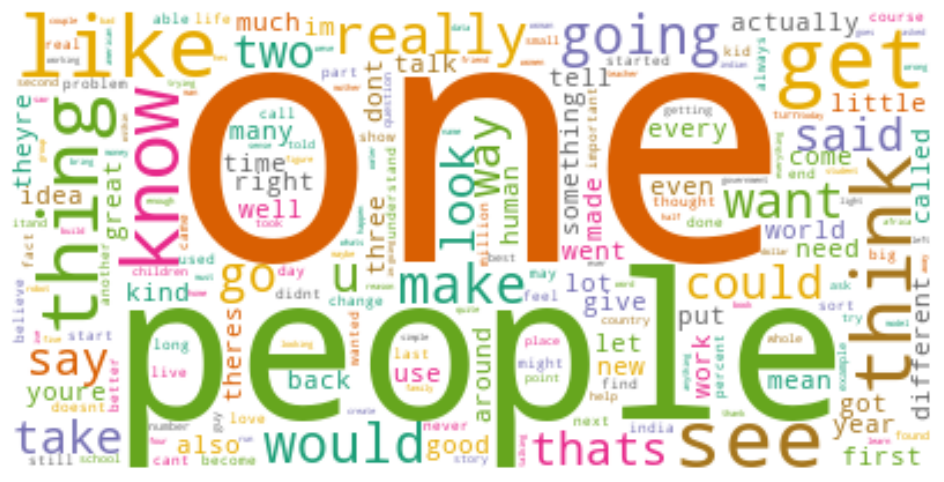

In [15]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150 )

wc.generate(corpus)

plt.rcParams["figure.figsize"] = (16,6)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
    
plt.show()

In [16]:
# Vectorize the data

input_texts = []
target_texts = []

input_characters = set()
target_characters = set()

In [17]:
for line in lines['english_sentence']:
    input_texts.append(line)
    for char in line:
        if re.findall("[a-zA-Z]", char) or char == ' ':
            if char not in input_characters:
                input_characters.add(char)
            
for line in lines['hindi_sentence']:
    
    target_text = '%' + line + '$'
    
    target_texts.append(line)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [18]:
target_characters

{' ',
 '$',
 '%',
 '¼',
 '½',
 'ँ',
 'ं',
 'ः',
 'अ',
 'आ',
 'इ',
 'ई',
 'उ',
 'ऊ',
 'ऋ',
 'ऍ',
 'ऎ',
 'ए',
 'ऐ',
 'ऑ',
 'ऒ',
 'ओ',
 'औ',
 'क',
 'ख',
 'ग',
 'घ',
 'ङ',
 'च',
 'छ',
 'ज',
 'झ',
 'ञ',
 'ट',
 'ठ',
 'ड',
 'ढ',
 'ण',
 'त',
 'थ',
 'द',
 'ध',
 'न',
 'प',
 'फ',
 'ब',
 'भ',
 'म',
 'य',
 'र',
 'ल',
 'ळ',
 'व',
 'श',
 'ष',
 'स',
 'ह',
 '़',
 'ा',
 'ि',
 'ी',
 'ु',
 'ू',
 'ृ',
 'ॄ',
 'ॅ',
 'ॆ',
 'े',
 'ै',
 'ॉ',
 'ॊ',
 'ो',
 'ौ',
 '्',
 'ॐ',
 '॓',
 '।',
 '॰',
 '\u200b',
 '\u200c',
 '‘',
 '“',
 '”',
 '…',
 '™',
 '♫'}

In [19]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples : ", len(input_texts))
print("Number of unique input tokens : ", num_encoder_tokens)
print("Number of unique output tokens : ", num_decoder_tokens)
print("Max sequence length for inputs : ", max_encoder_seq_length)
print("Max sequence length for outputs : ", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

print("Encoder input data : ", encoder_input_data.shape)
print("Decoder input data : ", decoder_input_data.shape)
print("Decoder target data : ", decoder_target_data.shape)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        if re.findall("[a-zA-Z]", char) or char == ' ': 
            encoder_input_data[i,t, input_token_index[char]] = 1
    encoder_input_data[i,t+1:, input_token_index[' ']] = 1
    
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1
        
        if t > 0:
            decoder_target_data[i, t-1, target_token_index[char]] = 1
            
    decoder_input_data[i,t+1:, target_token_index[' ']] = 1
    decoder_target_data[i, t:, target_token_index[' ']] = 1

encoder_input_data[0]



Number of samples :  25000
Number of unique input tokens :  27
Number of unique output tokens :  86
Max sequence length for inputs :  104
Max sequence length for outputs :  132
Encoder input data :  (25000, 104, 27)
Decoder input data :  (25000, 132, 86)
Decoder target data :  (25000, 132, 86)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [20]:
# Import necessary libraries
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Model
from nltk.translate.bleu_score import sentence_bleu

# Set parameters
batch_size = 128  # Batch size for training
epochs = 50  # Number of epochs to train for
latent_dim = 256  # Latent dimensionality of the encoding space

# Define encoder input data
encoder_inputs = Input(shape=(None, num_encoder_tokens))

# Use Bidirectional LSTM for the encoder
encoder = Bidirectional(LSTM(latent_dim, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)

# Combine forward and backward states
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

encoder_states = [state_h, state_c]

# Define decoder inputs
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# Use a regular LSTM for the decoder
decoder_lstm = LSTM(latent_dim * 2, return_sequences=True, return_state=True)  # Latent dim doubled due to BiLSTM
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Add a Dense layer with softmax activation
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

# Save checkpoint
checkpoint_path = "/kaggle/working/training_1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True, verbose=1
)

# Train the model
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[cp_callback],
)




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 27)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 512),     │    581,632 │ input_layer[0][0] │
│ (Bidirectional)     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None, 86)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  1,226,752 │ input_layer_1[0]… │
│                     │ 512), (None,      │            │ concatenate[0][0… │
│                     │ 512), (None,      │            │ concatenate_1[0]… │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 86)  │     44,118 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,852,502 (7.07 MB)

 Trainable params: 1,852,502 (7.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7350 - loss: 1.5958
Epoch 1: saving model to /kaggle/working/training_1/cp.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.7354 - loss: 1.5923 - val_accuracy: 0.7701 - val_loss: 1.0746
Epoch 2/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7727 - loss: 1.0499
Epoch 2: saving model to /kaggle/working/training_1/cp.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.7727 - loss: 1.0496 - val_accuracy: 0.7707 - val_loss: 0.9862
Epoch 3/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7727 - loss: 0.9715
Epoch 3: saving model to /kaggle/working/training_1/cp.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.7727 - loss: 0.9712 - val_accuracy: 0.7714 - val_loss: 0.9160
Epoch 4/50
156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.7827 - loss: 0.8662
Epoch 4: saving model to /kaggle/working/training_1/cp.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 12

In [22]:
# Define inference models
# Encoder inference model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder inference model
decoder_state_input_h = Input(shape=(latent_dim * 2,))
decoder_state_input_c = Input(shape=(latent_dim * 2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Save inference models
encoder_model.save("/kaggle/working/encoder_model.h5")
decoder_model.save("/kaggle/working/decoder_model.h5")

# Reverse target token index for decoding
reverse_target_char_index = {index: char for char, index in target_token_index.items()}

# Define sequence decoding function
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["%"]] = 1.0  # Start character
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        if sampled_char == "$" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return decoded_sentence

# BLEU score calculation
reference_sentences = []  # List to store reference sentences
decoded_sentences = []
bleu_scores = []
for seq_index in range(15):  # Adjust range to match data size
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(f"Input: {input_texts[seq_index]}")
    print(f"Decoded: {decoded_sentence}")

    if decoded_sentence:
        reference = [target_texts[seq_index].replace("%", "").replace("$", "").split()]
        hypothesis = decoded_sentence.replace("%", "").replace("$", "").split()
        bleu_score = sentence_bleu(reference, hypothesis)
        bleu_scores.append(bleu_score)
        print(f"BLEU score: {bleu_score}")
    else:
        print(f"Skipping BLEU calculation for input {seq_index} due to empty decoded sentence.")

if bleu_scores:
    average_bleu = np.mean(bleu_scores)
    print(f"Average BLEU Score: {average_bleu}")
else:
    print("No BLEU scores calculated. Check decoded sentences.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━